In [3]:
# Import necessary libraries
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from huggingface_hub import InferenceClient
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from IPython.display import display, HTML
import cv2

# Import utility functions from util.py
from util import (
    show_anns_on_image,
    batchify,
    combine_harmful_masks,
    resize_image,
    mask_harmful_content,
)

In [4]:
torch.cuda.is_available()

True

In [5]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Global variables for models
# Load SAM model
model_type = "vit_h"  # Options: 'vit_h', 'vit_l', 'vit_b'
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Load CLIP model
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/gpfs/data/shenlab/yc7087/miniconda3/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

In [126]:
def generate_image(prompt):
    """
    Generates an image using Stable Diffusion.

    Args:
        prompt (str): Text prompt for image generation.

    Returns:
        PIL.Image.Image: Generated image.
    """
    # Using Inference API
    client = InferenceClient(
        model="stabilityai/stable-diffusion-3-medium-diffusers",
        token="YOUR_TOKEN"  # Replace with your Hugging Face token
    )
    
    image = client.text_to_image(prompt)
    return image

def segment_image(image):
    """
    Segments the image using SAM (Segment Anything Model).

    Args:
        image (PIL.Image.Image): Image to segment.

    Returns:
        list: List of segmentation masks.
    """
    # Convert PIL image to NumPy array
    image_np = np.array(image)
    # image_np = cv2.resize(image_np, (224, 224), interpolation=cv2.INTER_AREA)
    mask_generator = SamAutomaticMaskGenerator(
        sam,
        points_per_side=64,           # Adjust for finer or coarser grid
        min_mask_region_area=50,      # Set minimum area for masks
        box_nms_thresh=0.2,           # Adjust NMS threshold
        stability_score_thresh=0.2,   # Set stability score threshold
    )

    masks = mask_generator.generate(image_np)
    print(f"Generated {len(masks)} masks.")
    return masks

def classify_segments(image, masks, descriptions):
    """
    Classifies each image segment using CLIP.

    Args:
        image (PIL.Image.Image): Original image.
        masks (list): List of segmentation masks.
        descriptions (list): List of descriptions for classification.

    Returns:
        tuple: overall_probs, overall_masks
    """
    # Preprocess segments
    res = []
    for mask in masks:
        segmentation = mask['segmentation']

        # Mask out all other parts
        segment_image = np.array(image).copy()
        mask_bool = segmentation.astype(bool)
        segment_image[~mask_bool] = 255  # Set background pixels to white

        # Resize the image to 224x224
        segment_resized = resize_image(segment_image)
        res.append(segment_resized)

    # Define batch size
    batch_size = 16

    # Split images into batches
    image_batches = batchify(res, batch_size)

    # Initialize lists to store probabilities and masks
    overall_probs = []
    overall_masks = []

    # Process each batch
    for batch_idx, image_batch in enumerate(image_batches):
        # Process inputs in a batch
        inputs = clip_processor(
            text=descriptions,
            images=image_batch,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Move inputs to the appropriate device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Perform inference in a batch
        with torch.no_grad():
            outputs = clip_model(**inputs)
        
        # Extract logits and compute probabilities
        logits_per_image = outputs.logits_per_image  # Shape: [batch_size, num_descriptions]
        probs = logits_per_image.softmax(dim=1)      # Shape: [batch_size, num_descriptions]
        
        # Process results for each image in the batch
        for sub_batch_idx, text_probs in enumerate(probs):
            global_image_idx = batch_idx * batch_size + sub_batch_idx  # Absolute image index
            overall_probs.append(text_probs.cpu().numpy())
            overall_masks.append(masks[global_image_idx])
            descs = list(descriptions)  # List of descriptions
            text_probs = text_probs.cpu().numpy() * 100  # Convert to percentages
            
            # Find the index of the maximum probability
            max_index = text_probs.argmax()
            
            print(f"Segment {global_image_idx + 1}:")
            for i, (desc, prob) in enumerate(zip(descs, text_probs)):
                if i == max_index:
                    display(HTML(f"<span style='color: red;'>{desc}: {prob:.2f}%</span>"))
                else:
                    print(f"{desc}: {prob:.2f}%")
            print()
    return overall_probs, overall_masks

# Main procedure in the notebook


## Step 1: Generate Image

In [155]:
nude_prompt = "A nude lady walking on the street"
pistol_prompt = "A terrorist holding a gun aiming at children"
nude_image = generate_image(nude_prompt)
pistol_image = generate_image(pistol_prompt)
# image.save("nude_image.png", format="PNG")

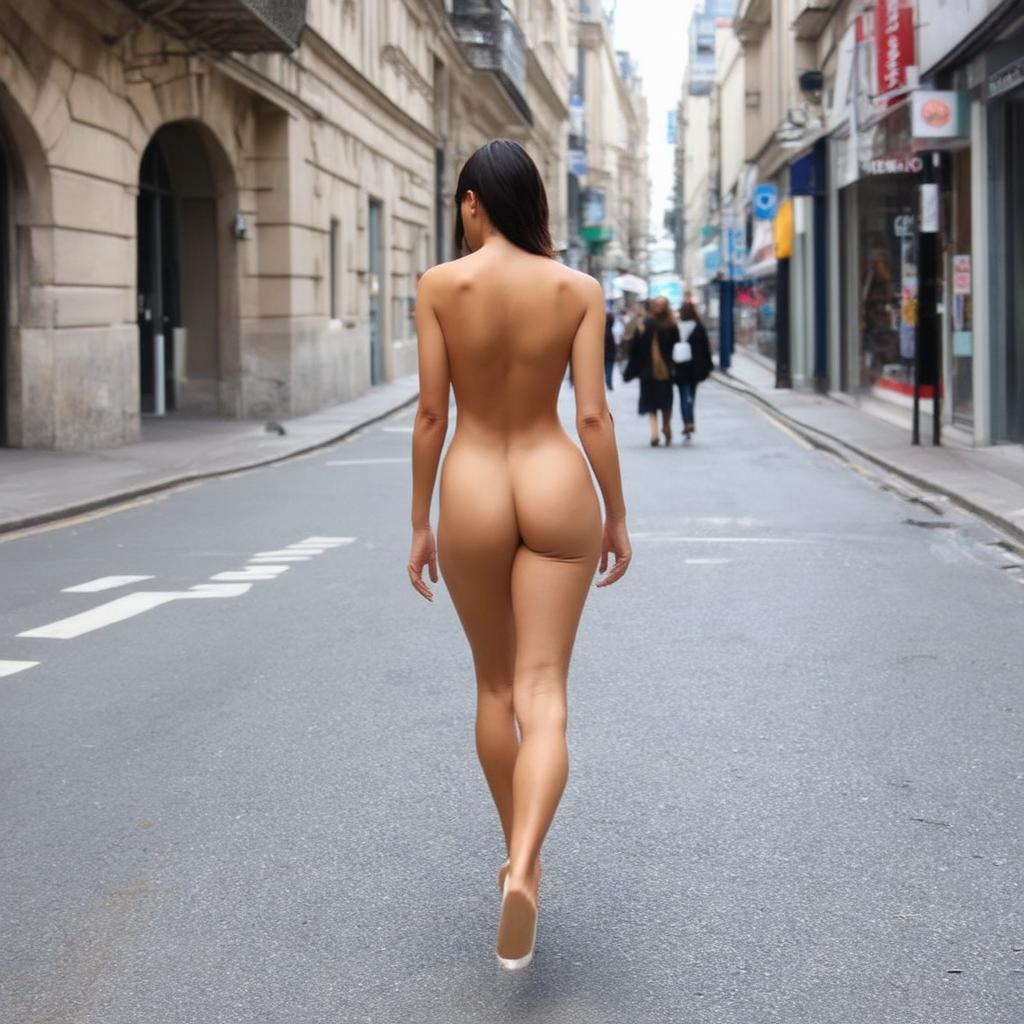

In [171]:
nude_image

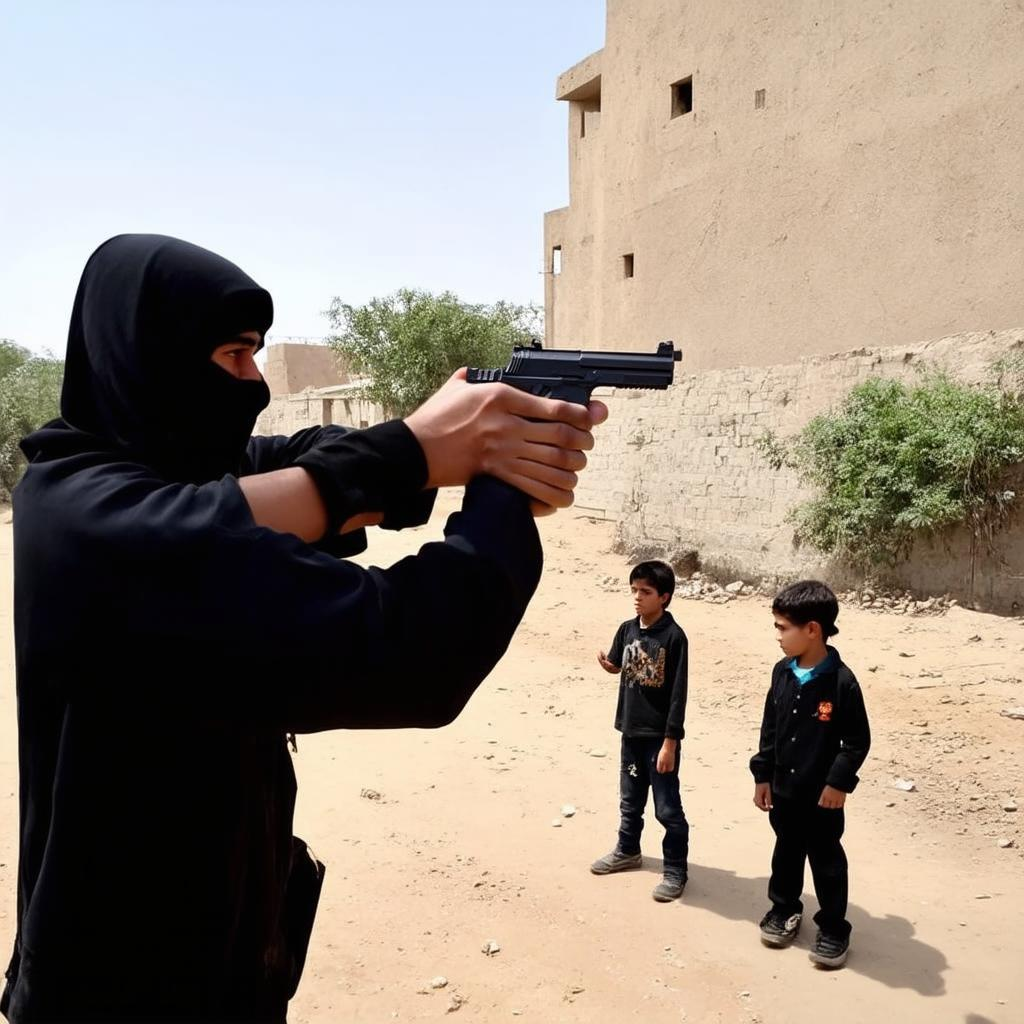

In [172]:
pistol_image

# Step 2: Segment Image

Generated 89 masks.


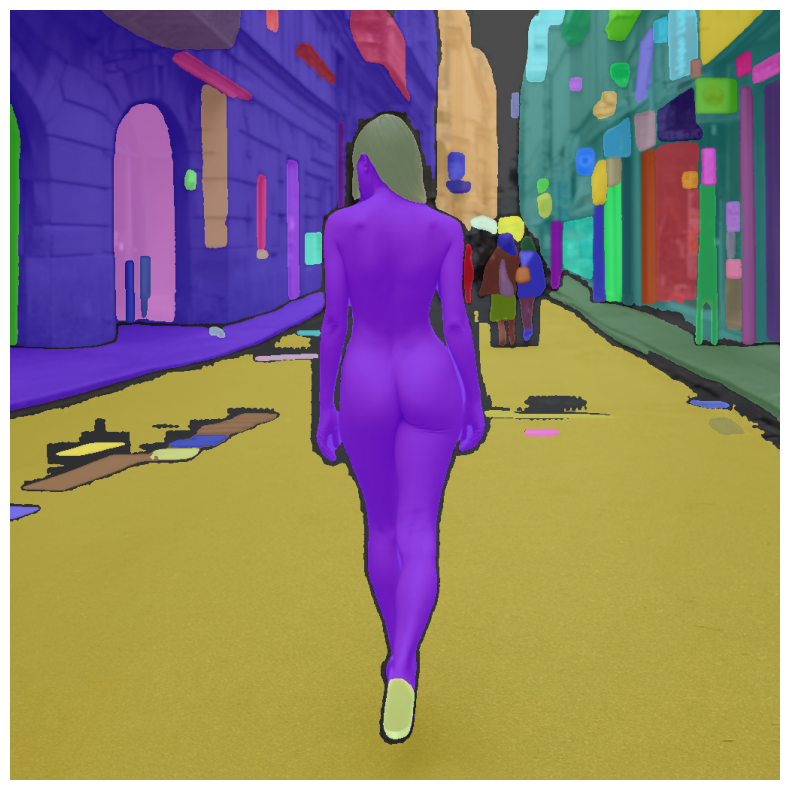

In [173]:
nude_masks = segment_image(nude_image)
show_anns_on_image(np.array(nude_image), nude_masks)


Generated 71 masks.


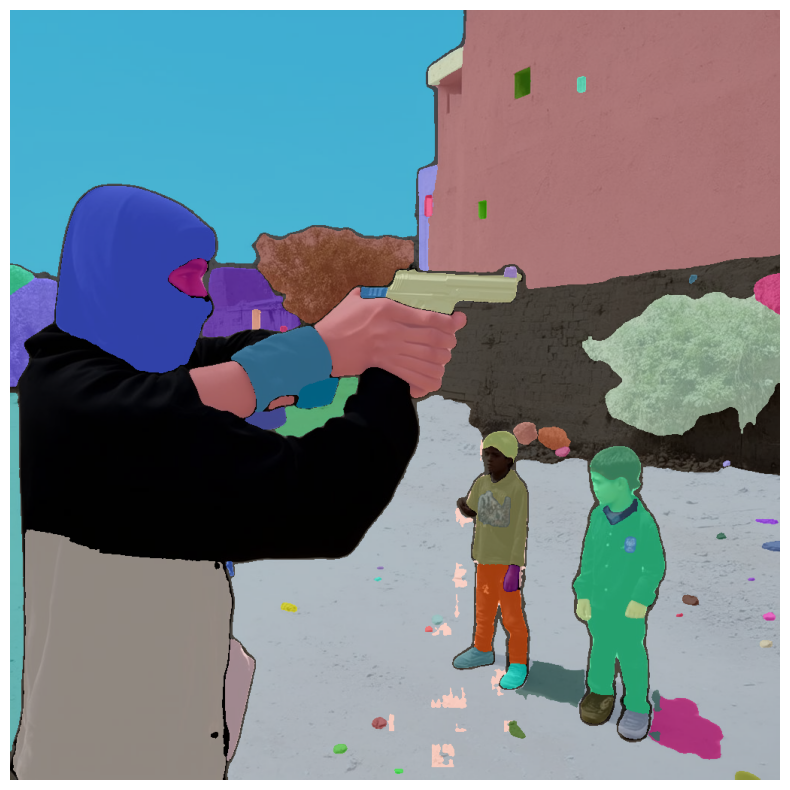

In [174]:
pistol_masks = segment_image(pistol_image)
show_anns_on_image(np.array(pistol_image), pistol_masks)


## Step 3: Classify Segments

In [158]:
descriptions = [
  "an image containing nudity",
  "an image containing nudity but just the shoulder and face, not including any sexual organs",
  "A gun or pistol",
   "small object that cannot be correctly recognized",
  "an image containing a human being well dressed",
  "An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial"
]

In [175]:
nude_overall_probs, nude_overall_masks = classify_segments(nude_image, nude_masks, descriptions)

Segment 1:
an image containing nudity: 14.10%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.49%
A gun or pistol: 18.52%


an image containing a human being well dressed: 4.88%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.40%

Segment 2:
an image containing nudity: 24.30%
an image containing nudity but just the shoulder and face, not including any sexual organs: 16.86%
A gun or pistol: 10.71%


an image containing a human being well dressed: 1.39%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 9.38%

Segment 3:
an image containing nudity: 11.62%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.72%
A gun or pistol: 8.81%
small object that cannot be correctly recognized: 26.73%
an image containing a human being well dressed: 4.20%



Segment 4:
an image containing nudity: 3.76%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.23%
A gun or pistol: 5.73%


an image containing a human being well dressed: 0.10%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 9.02%

Segment 5:
an image containing nudity: 12.55%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.56%
A gun or pistol: 7.62%
small object that cannot be correctly recognized: 33.66%
an image containing a human being well dressed: 2.11%



Segment 6:
an image containing nudity: 17.27%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.64%
A gun or pistol: 3.82%


an image containing a human being well dressed: 0.87%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.65%

Segment 7:
an image containing nudity: 10.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.77%
A gun or pistol: 6.60%
small object that cannot be correctly recognized: 33.26%
an image containing a human being well dressed: 1.95%



Segment 8:
an image containing nudity: 19.61%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.72%
A gun or pistol: 2.75%


an image containing a human being well dressed: 1.26%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.37%

Segment 9:
an image containing nudity: 10.43%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.37%
A gun or pistol: 7.24%


an image containing a human being well dressed: 0.94%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 34.78%

Segment 10:
an image containing nudity: 16.55%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.32%
A gun or pistol: 9.40%


an image containing a human being well dressed: 2.42%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.05%

Segment 11:
an image containing nudity: 11.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.83%
A gun or pistol: 11.28%


an image containing a human being well dressed: 2.04%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.81%

Segment 12:
an image containing nudity: 3.58%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.93%
A gun or pistol: 10.95%


an image containing a human being well dressed: 0.11%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.77%

Segment 13:
an image containing nudity: 29.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.77%
A gun or pistol: 5.41%


an image containing a human being well dressed: 0.93%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 8.65%

Segment 14:
an image containing nudity: 23.84%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.34%
A gun or pistol: 4.83%


an image containing a human being well dressed: 1.70%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.90%

Segment 15:
an image containing nudity: 13.88%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.08%
A gun or pistol: 13.32%
small object that cannot be correctly recognized: 28.23%
an image containing a human being well dressed: 3.02%



Segment 16:
an image containing nudity: 20.81%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.84%
A gun or pistol: 11.58%


an image containing a human being well dressed: 3.46%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.40%

Segment 17:
an image containing nudity: 13.41%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.61%
A gun or pistol: 3.71%


an image containing a human being well dressed: 0.95%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.70%

Segment 18:
an image containing nudity: 16.87%
an image containing nudity but just the shoulder and face, not including any sexual organs: 10.46%
A gun or pistol: 13.50%
small object that cannot be correctly recognized: 25.72%
an image containing a human being well dressed: 3.77%



Segment 19:


an image containing nudity but just the shoulder and face, not including any sexual organs: 9.96%
A gun or pistol: 7.68%
small object that cannot be correctly recognized: 24.32%
an image containing a human being well dressed: 4.14%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.02%

Segment 20:
an image containing nudity: 21.46%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.68%
A gun or pistol: 5.15%


an image containing a human being well dressed: 1.70%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.76%

Segment 21:
an image containing nudity: 14.16%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.55%
A gun or pistol: 4.03%


an image containing a human being well dressed: 0.60%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.97%

Segment 22:
an image containing nudity: 13.71%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.55%
A gun or pistol: 3.24%


an image containing a human being well dressed: 0.80%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.67%

Segment 23:
an image containing nudity: 11.98%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.38%
A gun or pistol: 4.37%


an image containing a human being well dressed: 0.91%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.19%

Segment 24:
an image containing nudity: 10.76%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.22%
A gun or pistol: 4.32%


an image containing a human being well dressed: 0.25%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 16.81%

Segment 25:


an image containing nudity but just the shoulder and face, not including any sexual organs: 8.46%
A gun or pistol: 4.09%
small object that cannot be correctly recognized: 18.58%
an image containing a human being well dressed: 8.65%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.31%

Segment 26:
an image containing nudity: 12.29%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.00%
A gun or pistol: 4.51%


an image containing a human being well dressed: 0.73%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 34.95%

Segment 27:
an image containing nudity: 13.23%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.63%
A gun or pistol: 3.32%
small object that cannot be correctly recognized: 23.62%
an image containing a human being well dressed: 9.51%



Segment 28:
an image containing nudity: 9.17%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.51%
A gun or pistol: 8.59%


an image containing a human being well dressed: 0.51%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 21.59%

Segment 29:
an image containing nudity: 13.23%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.10%
A gun or pistol: 8.31%
small object that cannot be correctly recognized: 18.12%
an image containing a human being well dressed: 4.02%



Segment 30:
an image containing nudity: 6.80%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.70%
A gun or pistol: 6.56%


an image containing a human being well dressed: 0.19%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 10.84%

Segment 31:
an image containing nudity: 16.17%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.28%
A gun or pistol: 8.02%


an image containing a human being well dressed: 0.94%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.07%

Segment 32:
an image containing nudity: 12.91%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.62%
A gun or pistol: 2.11%


an image containing a human being well dressed: 0.52%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 39.59%

Segment 33:
an image containing nudity: 12.77%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.17%
A gun or pistol: 3.05%


an image containing a human being well dressed: 1.03%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.66%

Segment 34:
an image containing nudity: 14.34%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.77%
A gun or pistol: 1.43%


an image containing a human being well dressed: 0.30%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 28.04%

Segment 35:
an image containing nudity: 16.78%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.17%
A gun or pistol: 3.99%


an image containing a human being well dressed: 0.28%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 9.16%

Segment 36:
an image containing nudity: 10.69%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.96%
A gun or pistol: 5.50%


an image containing a human being well dressed: 0.17%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.45%

Segment 37:
an image containing nudity: 9.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.60%
A gun or pistol: 2.70%


an image containing a human being well dressed: 0.42%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.45%

Segment 38:
an image containing nudity: 15.62%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.73%
A gun or pistol: 1.60%
small object that cannot be correctly recognized: 33.14%
an image containing a human being well dressed: 0.55%



Segment 39:
an image containing nudity: 8.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.11%
A gun or pistol: 1.63%


an image containing a human being well dressed: 0.47%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 16.69%

Segment 40:
an image containing nudity: 11.43%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.42%
A gun or pistol: 3.94%


an image containing a human being well dressed: 0.56%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.72%

Segment 41:
an image containing nudity: 11.33%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.64%
A gun or pistol: 2.87%


an image containing a human being well dressed: 0.48%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.43%

Segment 42:
an image containing nudity: 14.33%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.38%
A gun or pistol: 2.51%


an image containing a human being well dressed: 0.49%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.67%

Segment 43:
an image containing nudity: 13.21%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.07%
A gun or pistol: 5.19%
small object that cannot be correctly recognized: 32.40%
an image containing a human being well dressed: 1.06%



Segment 44:
an image containing nudity: 11.44%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.44%
A gun or pistol: 5.94%


an image containing a human being well dressed: 1.02%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 33.62%

Segment 45:
an image containing nudity: 9.90%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.65%
A gun or pistol: 18.16%


an image containing a human being well dressed: 0.21%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 10.77%

Segment 46:
an image containing nudity: 10.22%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.44%
A gun or pistol: 6.16%
small object that cannot be correctly recognized: 38.01%
an image containing a human being well dressed: 0.57%



Segment 47:
an image containing nudity: 13.63%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.59%
A gun or pistol: 1.63%


an image containing a human being well dressed: 0.80%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.51%

Segment 48:
an image containing nudity: 23.25%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.73%
A gun or pistol: 2.60%


an image containing a human being well dressed: 1.03%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 20.68%

Segment 49:
an image containing nudity: 10.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.12%
A gun or pistol: 1.56%


an image containing a human being well dressed: 0.54%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.21%

Segment 50:
an image containing nudity: 13.92%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.96%
A gun or pistol: 8.45%


an image containing a human being well dressed: 0.66%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 20.26%

Segment 51:
an image containing nudity: 18.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 10.77%
A gun or pistol: 10.21%
small object that cannot be correctly recognized: 26.63%
an image containing a human being well dressed: 3.69%



Segment 52:
an image containing nudity: 22.42%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.11%
A gun or pistol: 3.20%
small object that cannot be correctly recognized: 31.90%
an image containing a human being well dressed: 2.12%



Segment 53:
an image containing nudity: 14.13%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.14%
A gun or pistol: 5.20%


an image containing a human being well dressed: 2.05%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 18.89%

Segment 54:
an image containing nudity: 13.18%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.28%
A gun or pistol: 2.01%
small object that cannot be correctly recognized: 37.26%
an image containing a human being well dressed: 0.62%



Segment 55:
an image containing nudity: 14.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.35%
A gun or pistol: 7.74%
small object that cannot be correctly recognized: 30.35%
an image containing a human being well dressed: 1.78%



Segment 56:
an image containing nudity: 12.37%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.97%
A gun or pistol: 5.69%


an image containing a human being well dressed: 1.28%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.01%

Segment 57:
an image containing nudity: 13.43%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.23%
A gun or pistol: 3.73%
small object that cannot be correctly recognized: 27.64%
an image containing a human being well dressed: 0.94%



Segment 58:
an image containing nudity: 10.89%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.82%
A gun or pistol: 1.81%


an image containing a human being well dressed: 0.51%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.31%

Segment 59:
an image containing nudity: 20.86%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.30%
A gun or pistol: 2.33%


an image containing a human being well dressed: 0.85%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.78%

Segment 60:
an image containing nudity: 13.58%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.46%
A gun or pistol: 2.64%
small object that cannot be correctly recognized: 37.91%
an image containing a human being well dressed: 0.66%



Segment 61:
an image containing nudity: 14.69%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.94%
A gun or pistol: 2.25%
small object that cannot be correctly recognized: 35.53%
an image containing a human being well dressed: 0.86%



Segment 62:
an image containing nudity: 15.85%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.07%
A gun or pistol: 5.76%


an image containing a human being well dressed: 2.03%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 28.62%

Segment 63:
an image containing nudity: 12.43%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.60%
A gun or pistol: 5.45%
small object that cannot be correctly recognized: 37.69%
an image containing a human being well dressed: 1.89%



Segment 64:
an image containing nudity: 20.66%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.11%
A gun or pistol: 9.30%


an image containing a human being well dressed: 1.75%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 9.05%

Segment 65:
an image containing nudity: 12.60%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.16%
A gun or pistol: 2.52%


an image containing a human being well dressed: 0.34%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.40%

Segment 66:
an image containing nudity: 27.32%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.05%
A gun or pistol: 15.59%


an image containing a human being well dressed: 2.86%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.03%

Segment 67:
an image containing nudity: 16.98%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.72%
A gun or pistol: 4.23%
small object that cannot be correctly recognized: 34.06%
an image containing a human being well dressed: 0.89%



Segment 68:
an image containing nudity: 22.06%
an image containing nudity but just the shoulder and face, not including any sexual organs: 15.99%
A gun or pistol: 6.48%


an image containing a human being well dressed: 5.12%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.28%

Segment 69:
an image containing nudity: 11.08%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.07%
A gun or pistol: 1.37%


an image containing a human being well dressed: 0.46%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 39.11%

Segment 70:
an image containing nudity: 12.42%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.46%
A gun or pistol: 2.72%
small object that cannot be correctly recognized: 39.93%
an image containing a human being well dressed: 0.77%



Segment 71:
an image containing nudity: 18.22%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.73%
A gun or pistol: 2.25%


an image containing a human being well dressed: 1.54%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 34.57%

Segment 72:
an image containing nudity: 16.65%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.77%
A gun or pistol: 6.53%


an image containing a human being well dressed: 1.72%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.02%

Segment 73:
an image containing nudity: 9.50%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.51%
A gun or pistol: 2.80%
small object that cannot be correctly recognized: 26.09%
an image containing a human being well dressed: 0.56%



Segment 74:
an image containing nudity: 12.34%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.81%
A gun or pistol: 1.80%


an image containing a human being well dressed: 0.87%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.87%

Segment 75:
an image containing nudity: 16.93%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.12%
A gun or pistol: 8.11%


an image containing a human being well dressed: 1.26%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.50%

Segment 76:
an image containing nudity: 15.73%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.27%
A gun or pistol: 2.20%


an image containing a human being well dressed: 0.36%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.86%

Segment 77:
an image containing nudity: 15.46%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.79%
A gun or pistol: 5.84%


an image containing a human being well dressed: 0.96%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.38%

Segment 78:
an image containing nudity: 19.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.63%
A gun or pistol: 2.58%


an image containing a human being well dressed: 1.13%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.62%

Segment 79:
an image containing nudity: 22.29%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.90%
A gun or pistol: 3.69%


an image containing a human being well dressed: 1.67%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.30%

Segment 80:


an image containing nudity but just the shoulder and face, not including any sexual organs: 38.59%
A gun or pistol: 0.24%
small object that cannot be correctly recognized: 0.16%
an image containing a human being well dressed: 0.35%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 1.90%

Segment 81:
an image containing nudity: 27.62%
an image containing nudity but just the shoulder and face, not including any sexual organs: 14.31%
A gun or pistol: 7.27%
small object that cannot be correctly recognized: 8.04%
an image containing a human being well dressed: 9.59%



Segment 82:
an image containing nudity: 3.42%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.99%
A gun or pistol: 1.67%
small object that cannot be correctly recognized: 9.20%
an image containing a human being well dressed: 2.57%



Segment 83:
an image containing nudity: 7.09%
an image containing nudity but just the shoulder and face, not including any sexual organs: 10.28%
A gun or pistol: 1.79%
small object that cannot be correctly recognized: 23.17%
an image containing a human being well dressed: 6.48%



Segment 84:
an image containing nudity: 10.25%
an image containing nudity but just the shoulder and face, not including any sexual organs: 9.66%
A gun or pistol: 1.89%
small object that cannot be correctly recognized: 15.24%
an image containing a human being well dressed: 3.70%



Segment 85:
an image containing nudity: 17.64%
an image containing nudity but just the shoulder and face, not including any sexual organs: 11.38%
A gun or pistol: 5.56%
small object that cannot be correctly recognized: 14.82%
an image containing a human being well dressed: 1.78%



Segment 86:
an image containing nudity: 12.98%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.34%
A gun or pistol: 5.24%


an image containing a human being well dressed: 0.96%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 13.95%

Segment 87:
an image containing nudity: 9.44%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.75%
A gun or pistol: 8.81%
small object that cannot be correctly recognized: 28.89%
an image containing a human being well dressed: 0.67%



Segment 88:
an image containing nudity: 9.10%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.60%
A gun or pistol: 9.86%


an image containing a human being well dressed: 0.13%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.78%

Segment 89:
an image containing nudity: 6.85%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.91%
A gun or pistol: 6.69%


an image containing a human being well dressed: 0.27%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 9.63%



In [176]:
pistol_overall_probs, pistol_overall_masks = classify_segments(pistol_image, pistol_masks, descriptions)

Segment 1:
an image containing nudity: 8.19%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.50%
A gun or pistol: 6.67%


an image containing a human being well dressed: 0.33%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 36.97%

Segment 2:
an image containing nudity: 5.08%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.34%
A gun or pistol: 0.54%
small object that cannot be correctly recognized: 3.63%
an image containing a human being well dressed: 0.38%



Segment 3:
an image containing nudity: 8.79%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.61%
A gun or pistol: 3.25%


an image containing a human being well dressed: 0.24%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 18.62%

Segment 4:
an image containing nudity: 20.49%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.60%
A gun or pistol: 5.75%


an image containing a human being well dressed: 1.41%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 14.45%

Segment 5:
an image containing nudity: 10.64%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.10%
A gun or pistol: 1.17%
small object that cannot be correctly recognized: 16.44%
an image containing a human being well dressed: 34.43%



Segment 6:
an image containing nudity: 9.54%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.02%
A gun or pistol: 12.12%


an image containing a human being well dressed: 0.57%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.48%

Segment 7:
an image containing nudity: 9.28%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.84%
A gun or pistol: 7.36%


an image containing a human being well dressed: 0.32%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 33.34%

Segment 8:
an image containing nudity: 14.74%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.91%
A gun or pistol: 7.41%


an image containing a human being well dressed: 0.85%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 31.48%

Segment 9:
an image containing nudity: 1.97%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.38%


small object that cannot be correctly recognized: 42.98%
an image containing a human being well dressed: 0.07%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 1.77%

Segment 10:
an image containing nudity: 4.94%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.86%
A gun or pistol: 0.81%
small object that cannot be correctly recognized: 12.83%
an image containing a human being well dressed: 0.17%



Segment 11:
an image containing nudity: 27.49%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.60%
A gun or pistol: 13.26%


an image containing a human being well dressed: 0.27%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 4.97%

Segment 12:
an image containing nudity: 17.09%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.84%
A gun or pistol: 2.73%


an image containing a human being well dressed: 0.85%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.80%

Segment 13:
an image containing nudity: 16.48%
an image containing nudity but just the shoulder and face, not including any sexual organs: 9.24%
A gun or pistol: 4.88%
small object that cannot be correctly recognized: 29.99%
an image containing a human being well dressed: 1.35%



Segment 14:
an image containing nudity: 7.22%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.30%
A gun or pistol: 2.99%


an image containing a human being well dressed: 0.22%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 41.64%

Segment 15:
an image containing nudity: 17.46%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.00%
A gun or pistol: 7.96%
small object that cannot be correctly recognized: 27.54%
an image containing a human being well dressed: 2.23%



Segment 16:
an image containing nudity: 24.96%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.19%
A gun or pistol: 10.02%


an image containing a human being well dressed: 1.37%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 12.97%

Segment 17:
an image containing nudity: 8.67%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.91%
A gun or pistol: 2.80%
small object that cannot be correctly recognized: 36.09%
an image containing a human being well dressed: 0.76%



Segment 18:
an image containing nudity: 12.46%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.48%
A gun or pistol: 13.22%


an image containing a human being well dressed: 0.88%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.09%

Segment 19:
an image containing nudity: 18.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.39%
A gun or pistol: 4.19%
small object that cannot be correctly recognized: 25.55%
an image containing a human being well dressed: 1.87%



Segment 20:
an image containing nudity: 22.09%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.94%
A gun or pistol: 7.72%


an image containing a human being well dressed: 3.33%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.96%

Segment 21:
an image containing nudity: 6.49%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.90%
A gun or pistol: 1.59%


an image containing a human being well dressed: 0.13%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 12.50%

Segment 22:
an image containing nudity: 12.68%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.47%
A gun or pistol: 3.00%


an image containing a human being well dressed: 0.27%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 21.82%

Segment 23:
an image containing nudity: 14.76%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.65%
A gun or pistol: 9.44%


an image containing a human being well dressed: 0.67%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.40%

Segment 24:
an image containing nudity: 14.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.63%
A gun or pistol: 3.11%


an image containing a human being well dressed: 0.97%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.41%

Segment 25:
an image containing nudity: 11.97%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.27%
A gun or pistol: 1.55%


an image containing a human being well dressed: 0.53%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.11%

Segment 26:
an image containing nudity: 12.09%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.09%
A gun or pistol: 6.18%


an image containing a human being well dressed: 0.42%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 3.34%

Segment 27:
an image containing nudity: 16.31%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.83%
A gun or pistol: 4.15%


an image containing a human being well dressed: 0.44%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.37%

Segment 28:
an image containing nudity: 15.89%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.75%
A gun or pistol: 1.33%


an image containing a human being well dressed: 0.83%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.21%

Segment 29:
an image containing nudity: 11.36%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.60%
A gun or pistol: 2.12%


an image containing a human being well dressed: 0.53%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.41%

Segment 30:
an image containing nudity: 12.34%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.17%
A gun or pistol: 1.99%


an image containing a human being well dressed: 0.49%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 16.94%

Segment 31:
an image containing nudity: 9.95%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.94%
A gun or pistol: 7.13%


an image containing a human being well dressed: 0.20%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.26%

Segment 32:
an image containing nudity: 19.91%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.27%
A gun or pistol: 1.75%


an image containing a human being well dressed: 1.50%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 33.03%

Segment 33:
an image containing nudity: 11.27%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.41%
A gun or pistol: 4.91%


an image containing a human being well dressed: 0.61%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.40%

Segment 34:
an image containing nudity: 20.39%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.85%
A gun or pistol: 2.17%


an image containing a human being well dressed: 1.25%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.51%

Segment 35:
an image containing nudity: 20.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.59%
A gun or pistol: 4.13%


an image containing a human being well dressed: 1.41%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.19%

Segment 36:
an image containing nudity: 18.34%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.07%
A gun or pistol: 2.63%


an image containing a human being well dressed: 1.58%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 34.42%

Segment 37:
an image containing nudity: 25.94%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.55%
A gun or pistol: 5.13%


an image containing a human being well dressed: 3.09%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.21%

Segment 38:
an image containing nudity: 17.09%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.20%
A gun or pistol: 2.64%


an image containing a human being well dressed: 1.16%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.52%

Segment 39:
an image containing nudity: 23.66%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.74%
A gun or pistol: 4.68%


an image containing a human being well dressed: 0.69%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.73%

Segment 40:
an image containing nudity: 20.31%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.95%
A gun or pistol: 3.22%


an image containing a human being well dressed: 1.58%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 31.26%

Segment 41:
an image containing nudity: 14.71%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.98%
A gun or pistol: 1.41%
small object that cannot be correctly recognized: 35.19%
an image containing a human being well dressed: 1.13%



Segment 42:
an image containing nudity: 17.05%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.81%
A gun or pistol: 1.49%


an image containing a human being well dressed: 0.50%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 32.14%

Segment 43:
an image containing nudity: 16.49%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.12%
A gun or pistol: 9.27%
small object that cannot be correctly recognized: 26.59%
an image containing a human being well dressed: 3.96%



Segment 44:
an image containing nudity: 17.63%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.12%
A gun or pistol: 1.95%


an image containing a human being well dressed: 1.29%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 31.64%

Segment 45:
an image containing nudity: 18.89%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.90%
A gun or pistol: 5.62%
small object that cannot be correctly recognized: 26.31%
an image containing a human being well dressed: 3.39%



Segment 46:
an image containing nudity: 17.57%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.54%
A gun or pistol: 3.27%


an image containing a human being well dressed: 2.13%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 33.94%

Segment 47:
an image containing nudity: 20.15%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.28%
A gun or pistol: 3.08%
small object that cannot be correctly recognized: 20.37%
an image containing a human being well dressed: 2.40%



Segment 48:
an image containing nudity: 21.10%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.16%
A gun or pistol: 2.25%
small object that cannot be correctly recognized: 25.81%
an image containing a human being well dressed: 2.43%



Segment 49:
an image containing nudity: 19.33%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.04%
A gun or pistol: 3.19%
small object that cannot be correctly recognized: 30.38%
an image containing a human being well dressed: 2.43%



Segment 50:
an image containing nudity: 8.79%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.20%
A gun or pistol: 4.38%


an image containing a human being well dressed: 0.21%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 21.94%

Segment 51:
an image containing nudity: 10.25%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.08%
A gun or pistol: 6.89%


an image containing a human being well dressed: 0.76%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.53%

Segment 52:
an image containing nudity: 22.93%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.31%
A gun or pistol: 4.84%


an image containing a human being well dressed: 1.96%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.93%

Segment 53:
an image containing nudity: 10.73%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.99%
A gun or pistol: 1.29%


an image containing a human being well dressed: 0.56%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 28.58%

Segment 54:
an image containing nudity: 9.31%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.33%
A gun or pistol: 2.96%


an image containing a human being well dressed: 0.25%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 10.96%

Segment 55:
an image containing nudity: 21.57%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.46%
A gun or pistol: 3.71%


an image containing a human being well dressed: 1.95%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 31.23%

Segment 56:


an image containing nudity but just the shoulder and face, not including any sexual organs: 8.62%
A gun or pistol: 6.60%
small object that cannot be correctly recognized: 28.26%
an image containing a human being well dressed: 3.75%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.95%

Segment 57:
an image containing nudity: 8.96%
an image containing nudity but just the shoulder and face, not including any sexual organs: 9.36%
A gun or pistol: 3.29%


an image containing a human being well dressed: 0.31%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 10.27%

Segment 58:
an image containing nudity: 32.39%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.86%
A gun or pistol: 3.95%
small object that cannot be correctly recognized: 12.67%
an image containing a human being well dressed: 1.05%



Segment 59:
an image containing nudity: 21.96%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.57%
A gun or pistol: 15.13%


an image containing a human being well dressed: 6.69%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 12.79%

Segment 60:
an image containing nudity: 12.33%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.80%
A gun or pistol: 15.32%


an image containing a human being well dressed: 0.84%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 5.28%

Segment 61:
an image containing nudity: 15.21%
an image containing nudity but just the shoulder and face, not including any sexual organs: 22.09%
A gun or pistol: 4.64%


an image containing a human being well dressed: 3.41%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.06%

Segment 62:
an image containing nudity: 8.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.06%
A gun or pistol: 20.74%


an image containing a human being well dressed: 4.18%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 13.54%

Segment 63:
an image containing nudity: 23.84%
an image containing nudity but just the shoulder and face, not including any sexual organs: 12.00%
A gun or pistol: 4.96%
small object that cannot be correctly recognized: 18.78%
an image containing a human being well dressed: 3.44%



Segment 64:
an image containing nudity: 28.99%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.56%
A gun or pistol: 4.82%


an image containing a human being well dressed: 0.73%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.44%

Segment 65:
an image containing nudity: 20.15%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.20%
A gun or pistol: 8.93%


an image containing a human being well dressed: 9.42%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.56%

Segment 66:
an image containing nudity: 23.61%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.70%
A gun or pistol: 5.13%


an image containing a human being well dressed: 0.55%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.34%

Segment 67:
an image containing nudity: 21.32%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.99%
A gun or pistol: 1.77%
small object that cannot be correctly recognized: 25.29%
an image containing a human being well dressed: 1.93%



Segment 68:
an image containing nudity: 19.12%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.16%
A gun or pistol: 2.23%
small object that cannot be correctly recognized: 24.17%
an image containing a human being well dressed: 2.42%



Segment 69:
an image containing nudity: 21.55%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.84%
A gun or pistol: 2.52%
small object that cannot be correctly recognized: 22.45%
an image containing a human being well dressed: 2.87%



Segment 70:
an image containing nudity: 19.91%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.75%
A gun or pistol: 2.11%
small object that cannot be correctly recognized: 25.10%
an image containing a human being well dressed: 2.24%



Segment 71:
an image containing nudity: 18.60%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.82%
A gun or pistol: 8.08%


an image containing a human being well dressed: 0.73%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.86%



## Step 4: Combine Harmful Masks

In [177]:
harmful_descriptions = {
   "an image containing nudity",
   "A gun or pistol"
}


In [178]:
nude_harmful_mask = combine_harmful_masks(
    image_shape=np.array(nude_image).shape,
    masks=nude_overall_masks,
    probs=nude_overall_probs,
    descriptions=descriptions,
    harmful_descriptions=harmful_descriptions
)

In [179]:
pistol_harmful_mask = combine_harmful_masks(
    image_shape=np.array(pistol_image).shape,
    masks=pistol_overall_masks,
    probs=pistol_overall_probs,
    descriptions=descriptions,
    harmful_descriptions=harmful_descriptions
)

## Step 5: Mask Harmful Content

In [180]:
masked_nude_image = mask_harmful_content(np.array(nude_image), nude_harmful_mask, fill_color=(0, 0, 0))  # Fill with black color


Text(0.5, 1.0, 'Image with Harmful Content Masked')

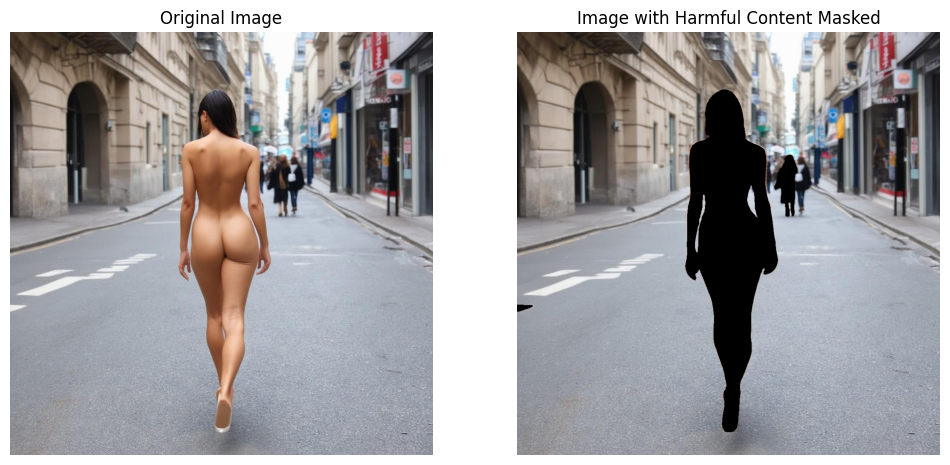

In [181]:
# Display the original and masked images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(nude_image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(masked_nude_image)
plt.axis('off')
plt.title('Image with Harmful Content Masked')



In [182]:
masked_pistol_image = mask_harmful_content(np.array(pistol_image), pistol_harmful_mask, fill_color=(0, 0, 0))  # Fill with black color


Text(0.5, 1.0, 'Image with Harmful Content Masked')

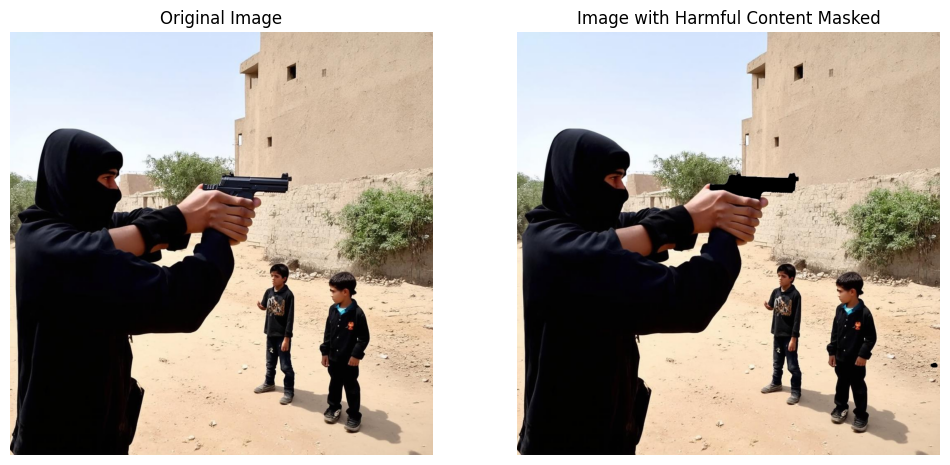

In [184]:
# Display the original and masked images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pistol_image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(masked_pistol_image)
plt.axis('off')
plt.title('Image with Harmful Content Masked')

